In [1]:
from cosmic.sample.initialbinarytable import InitialBinaryTable
from cosmic.evolve import Evolve
from cosmic.utils import convert_kstar_evol_type
from cosmic.plotting import evolve_and_plot

import numpy as np
import matplotlib.pyplot as plt
import tqdm
from matplotlib.colors import LogNorm

In [2]:
# Helper functions and variables for unit conversions

def aui_to_porb(aui, m_tot):
    # aui: a list of values, initial separation in AU
    # m_tot: a list of values, total mass in M_sun
    # result: a list of values, orbital period in given condition in days
    res = []
    for i in range(len(aui)):
        res.append((1/m_tot[i]**0.5) * (aui[i]**1.5) * 365)
    return res

# Used to convert separation in R_sun into AU
unit_factor = 1 / 215.032

# Helper function: given an array of data and an array of target,
# return an array of index that is nearest to the target value.
import math 
def findNearestList(data, targetList):
    res = []
    for num in targetList:
        res.append(findNearest(data, num))
    return res

def findNearest(data, target):
    n = len(data)
    res = -1
    minDiff = 10**5
    for i in range(n):
        if data[i] == 10**(-5):
            continue
        if abs(target - data[i]) <= minDiff:
            res = i
            minDiff = abs(target - data[i])
    return res

In [3]:
NUM_DICT = 2000
NUM_SEP = 400

MASS_1 = 7
MASS_2 = 1
MASS_TOT = 8

ECC = 0

SEP_START = 2
SEP_END = 8

LAMBDA_START = -100
LAMBDA_END = 0

SOLAR_MET = 0.02

TPHYS_LIM = 200

In [4]:
# Default BSEDict
BSEDict = {'xi': 1.0, 'bhflag': 1, 'neta': 0.5, 'windflag': 3, 'wdflag': 1, 'alpha1': 1.0, 'pts1': 0.001, 
           'pts3': 0.02, 'pts2': 0.01, 'epsnov': 0.001, 'hewind': 0.5, 'ck': 1000, 'bwind': 0.0, 'lambdaf': 0.0, 
           'mxns': 3.0, 'beta': -1.0, 'tflag': 1, 'acc2': 1.5, 'grflag' : 1, 'remnantflag': 4, 'ceflag': 0, 
           'eddfac': 1.0, 'ifflag': 0, 'bconst': 3000, 'sigma': 265.0, 'gamma': -2.0, 'pisn': 45.0, 
           'natal_kick_array' : [[-100.0,-100.0,-100.0,-100.0,0.0], [-100.0,-100.0,-100.0,-100.0,0.0]], 
           'bhsigmafrac' : 1.0, 'polar_kick_angle' : 90, 
           'qcrit_array' : [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0], 
           'cekickflag' : 2, 'cehestarflag' : 0, 'cemergeflag' : 0, 'ecsn' : 2.25, 'ecsn_mlow' : 1.6, 
           'aic' : 1, 'ussn' : 0, 'sigmadiv' :-20.0, 'qcflag' : 1, 'eddlimflag' : 0, 
           'fprimc_array' : [2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0], 
           'bhspinflag' : 0, 'bhspinmag' : 0.0, 'rejuv_fac' : 1.0, 'rejuvflag' : 0, 'htpmb' : 1, 'ST_cr' : 1, 
           'ST_tide' : 1, 'bdecayfac' : 1, 'rembar_massloss' : 0.5, 'kickflag' : 0, 'zsun' : 0.014, 'bhms_coll_flag' : 0, 
           'don_lim' : -1, 'acc_lim' : -1, 'rtmsflag' : 0, 'wd_mass_lim': 1}

In [5]:
# List of initial conditions for simulation later

m1_list = [MASS_1 for i in range(NUM_SEP)]
m2_list = [MASS_2 for i in range(NUM_SEP)]
mtot_list = [MASS_TOT for i in range(NUM_SEP)]
ai_list = np.linspace(SEP_START, SEP_END, NUM_SEP)
porb_i_list = aui_to_porb(ai_list, mtot_list)

ecc_list = [ECC for i in range(NUM_SEP)]
tphysf_list = [TPHYS_LIM for i in range(NUM_SEP)]
kstar1_list = [1 for i in range(NUM_SEP)]
kstar2_list = [1 for i in range(NUM_SEP)]
metallicity_list = [SOLAR_MET for i in range(NUM_SEP)] # solar metallicity

In [6]:
csv_file_path = '7+1 alpha=1 result.csv'
data1 = np.genfromtxt(csv_file_path, delimiter=',')

csv_file_path = '7+1 alpha=0.9 result.csv'
data2 = np.genfromtxt(csv_file_path, delimiter=',')

csv_file_path = '7+1 alpha=0.6 result.csv'
data3 = np.genfromtxt(csv_file_path, delimiter=',')

csv_file_path = '7+1 alpha=0.3 result.csv'
data4 = np.genfromtxt(csv_file_path, delimiter=',')

In [7]:
# Create a list of BSEDict for different lambdaf values
# lambdaf ranges from 0 to -10 with NUM_DICT values in between

lambdaList = np.linspace(LAMBDA_START, LAMBDA_END, NUM_DICT, endpoint=False)
print(lambdaList)

BSEDictList = [BSEDict.copy() for i in range(NUM_DICT)]
for i in range(NUM_DICT):
    BSEDictList[i]['lambdaf'] = lambdaList[i]

[-1.000e+02 -9.995e+01 -9.990e+01 ... -1.500e-01 -1.000e-01 -5.000e-02]


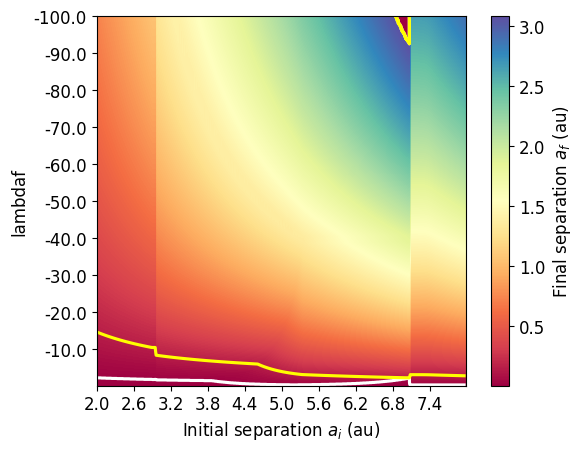

In [8]:
plt.imshow(data1, cmap='Spectral', aspect = 0.2)

cbar = plt.colorbar()  # Customize color bar label
cbar.ax.tick_params(labelsize=12)  # Adjust font size in color bar
cbar.ax.set_ylabel('Final separation $a_f$ (au)', fontsize=12)  # Add label to color bar
cbar.ax.figure.canvas.draw()

x_tick_locations = np.arange(0, data1.shape[1], 40)
y_tick_locations = np.arange(0, data1.shape[0], 200)
x_tick_labels = [f'{ai_list[i]:.1f}' for i in x_tick_locations]
y_tick_labels = [f'{lambdaList[i]:.1f}' for i in y_tick_locations]
plt.xticks(x_tick_locations, x_tick_labels, fontsize=12)
plt.yticks(y_tick_locations, y_tick_labels, fontsize=12)

plt.xlabel('Initial separation $a_i$ (au)', fontsize=12)  # Add X axis label
plt.ylabel('lambdaf', fontsize=12)  # Add Y axis label

plt.contour(data1, levels=[0.01, 0.15],colors=['white', 'yellow'],linewidths=2.25)
plt.savefig('7+1 Heatmap, alpha = 1', dpi=300)
plt.show()

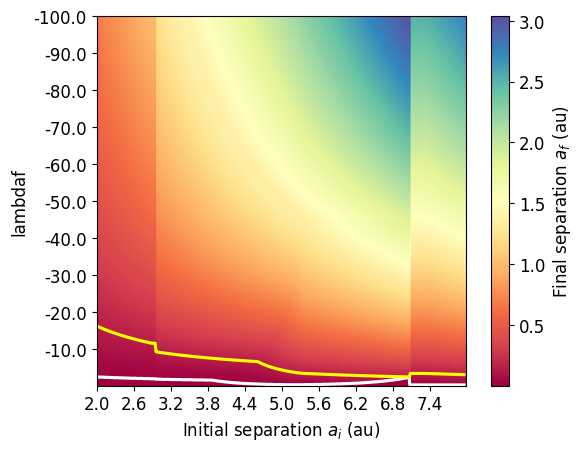

In [9]:
plt.imshow(data2, cmap='Spectral', aspect = 0.2)

cbar = plt.colorbar()  # Customize color bar label
cbar.ax.tick_params(labelsize=12)  # Adjust font size in color bar
cbar.ax.set_ylabel('Final separation $a_f$ (au)', fontsize=12)  # Add label to color bar
cbar.ax.figure.canvas.draw()

x_tick_locations = np.arange(0, data2.shape[1], 40)
y_tick_locations = np.arange(0, data2.shape[0], 200)
x_tick_labels = [f'{ai_list[i]:.1f}' for i in x_tick_locations]
y_tick_labels = [f'{lambdaList[i]:.1f}' for i in y_tick_locations]
plt.xticks(x_tick_locations, x_tick_labels, fontsize=12)
plt.yticks(y_tick_locations, y_tick_labels, fontsize=12)

plt.xlabel('Initial separation $a_i$ (au)', fontsize=12)  # Add X axis label
plt.ylabel('lambdaf', fontsize=12)  # Add Y axis label

plt.contour(data2, levels=[0.01, 0.15], colors=['white', 'yellow'],linewidths=2.25)
plt.savefig('7+1 Heatmap, alpha = 0.9.png', dpi=300)
plt.show()

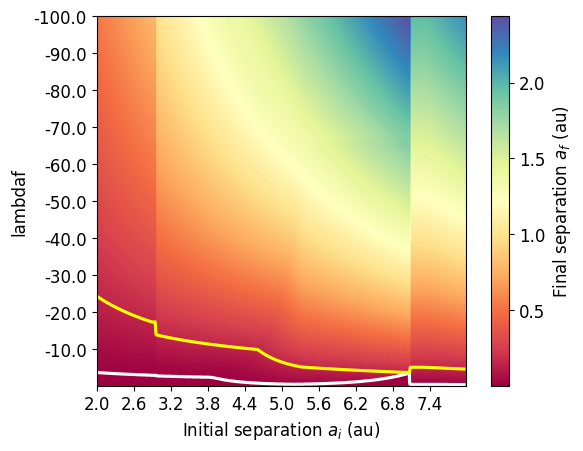

In [10]:
plt.imshow(data3, cmap='Spectral', aspect = 0.2)

cbar = plt.colorbar()  # Customize color bar label
cbar.ax.tick_params(labelsize=12)  # Adjust font size in color bar
cbar.ax.set_ylabel('Final separation $a_f$ (au)', fontsize=12)  # Add label to color bar
cbar.ax.figure.canvas.draw()

x_tick_locations = np.arange(0, data3.shape[1], 40)
y_tick_locations = np.arange(0, data3.shape[0], 200)
x_tick_labels = [f'{ai_list[i]:.1f}' for i in x_tick_locations]
y_tick_labels = [f'{lambdaList[i]:.1f}' for i in y_tick_locations]
plt.xticks(x_tick_locations, x_tick_labels, fontsize=12)
plt.yticks(y_tick_locations, y_tick_labels, fontsize=12)

plt.xlabel('Initial separation $a_i$ (au)', fontsize=12)  # Add X axis label
plt.ylabel('lambdaf', fontsize=12)  # Add Y axis label

plt.contour(data3, levels=[0.01, 0.15], colors=['white', 'yellow'],linewidths=2.25)
plt.savefig('7+1 Heatmap, alpha = 0.6.png', dpi=300)
plt.show()

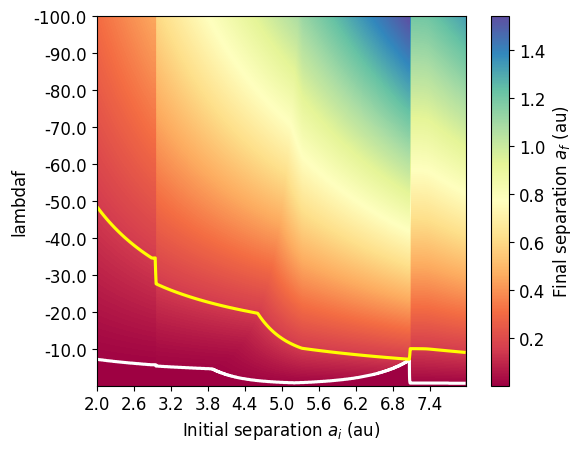

In [11]:
plt.imshow(data4, cmap='Spectral', aspect = 0.2)

cbar = plt.colorbar()  # Customize color bar label
cbar.ax.tick_params(labelsize=12)  # Adjust font size in color bar
cbar.ax.set_ylabel('Final separation $a_f$ (au)', fontsize=12)  # Add label to color bar
cbar.ax.figure.canvas.draw()

x_tick_locations = np.arange(0, data4.shape[1], 40)
y_tick_locations = np.arange(0, data4.shape[0], 200)
x_tick_labels = [f'{ai_list[i]:.1f}' for i in x_tick_locations]
y_tick_labels = [f'{lambdaList[i]:.1f}' for i in y_tick_locations]
plt.xticks(x_tick_locations, x_tick_labels, fontsize=12)
plt.yticks(y_tick_locations, y_tick_labels, fontsize=12)

plt.xlabel('Initial separation $a_i$ (au)', fontsize=12)  # Add X axis label
plt.ylabel('lambdaf', fontsize=12)  # Add Y axis label

plt.contour(data4, levels=[0.01, 0.15], colors=['white', 'yellow'],linewidths=2.25)
plt.savefig('7+1 Heatmap, alpha = 0.3.png', dpi=300)
plt.show()

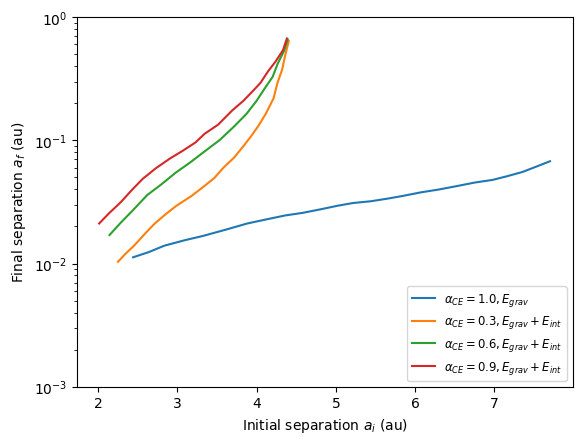

In [12]:
# Results in Yamaguchi 2023
x = [0, 0, 0, 0]
y = [0, 0, 0, 0]

x[0] = [2.4404761904761902, 2.642857142857143, 2.833333333333333, 3.083333333333333, 3.321428571428571, 3.6071428571428568, 3.880952380952381, 4.142857142857142, 4.357142857142857, 4.583333333333333, 4.809523809523809, 5.023809523809524, 5.214285714285714, 5.44047619047619, 5.654761904761904, 5.845238095238095, 6.071428571428571, 6.285714285714286, 6.523809523809524, 6.75, 6.976190476190475, 7.154761904761904, 7.357142857142857, 7.559523809523809, 7.702380952380952]
y[0] = [0.011234183573687356, 0.012412601587602478, 0.013944544486216936, 0.015407267817255156, 0.016742747005726248, 0.018809109339013287, 0.02113049871720325, 0.022962059095951007, 0.024540968429645055, 0.025795998711377114, 0.027569774441469845, 0.02946551793779906, 0.0309723907160626, 0.03201954545586311, 0.03365703173802061, 0.035378259412695706, 0.03781092730903451, 0.03974458607597561, 0.04247748984810421, 0.0453983126241806, 0.047719991870304346, 0.0510012977955693, 0.05542201486227198, 0.06226210889863927, 0.06765889641805466]
plt.plot(x[0], y[0], label = r'$\alpha_{CE} = 1.0, E_{grav}$')

x[1] = [2.25, 2.345238095238095, 2.452380952380952, 2.595238095238095, 2.714285714285714, 2.845238095238095, 2.988095238095238, 3.1785714285714284, 3.3095238095238093, 3.464285714285714, 3.583333333333333, 3.714285714285714, 3.833333333333333, 3.9285714285714284, 4.023809523809524, 4.119047619047619, 4.214285714285714, 4.261904761904762, 4.321428571428571, 4.357142857142857, 4.404761904761904]
y[1] = [0.010338092964602, 0.01200666470122069, 0.013944544486216936, 0.017598974605374764, 0.02113049871720325, 0.024952376419619688, 0.02946551793779906, 0.035378259412695706, 0.04108832256930621, 0.049333371222525825, 0.060225913146483526, 0.07231123454746669, 0.08975705447453801, 0.1077682857644978, 0.13156294122130663, 0.16604148409801042, 0.22027250401975687, 0.2922159862079623, 0.37497923628463475, 0.4811832147490381, 0.6383430754117011]
plt.plot(x[1], y[1], label = r'$\alpha_{CE} = 0.3, E_{grav} + E_{int}$')

x[2] = [2.142857142857143, 2.2857142857142856, 2.4285714285714284, 2.619047619047619, 2.7976190476190474, 2.976190476190476, 3.1666666666666665, 3.3571428571428568, 3.5357142857142856, 3.714285714285714, 3.8690476190476186, 4, 4.095238095238095, 4.2023809523809526, 4.261904761904762, 4.345238095238095, 4.392857142857142]
y[2] = [0.017023424596426327, 0.021484733148877305, 0.026668143279297, 0.035971345159719274, 0.043913623895263904, 0.054508231767973085, 0.06654335495173698, 0.08259761533183257, 0.10083472270004161, 0.12939376725996599, 0.1633038373073242, 0.20955577752775972, 0.2601132376832342, 0.3282808032226341, 0.41431296124858524, 0.5316572847635216, 0.659925005691611]
plt.plot(x[2], y[2], label = r'$\alpha_{CE} = 0.6, E_{grav} + E_{int}$')

x[3] = [2.011904761904762, 2.142857142857143, 2.2857142857142856, 2.4285714285714284, 2.5595238095238093, 2.726190476190476, 2.9047619047619047, 3.071428571428571, 3.226190476190476, 3.345238095238095, 3.511904761904762, 3.6904761904761902, 3.833333333333333, 3.952380952380952, 4.0476190476190474, 4.142857142857142, 4.238095238095238, 4.333333333333333, 4.3809523809523805]
y[3] = [0.02113049871720325, 0.025795998711377114, 0.03149161590661423, 0.03974458607597561, 0.0485199760271338, 0.05923292468497171, 0.07111898659651138, 0.08259761533183257, 0.09592889866684408, 0.11327957854141268, 0.13376847949736032, 0.17453288048133356, 0.20955577752775972, 0.25160659569794086, 0.2922159862079623, 0.3627160614327777, 0.4355010131370727, 0.5405700567067716, 0.6709880744088835]
plt.plot(x[3], y[3], label = r'$\alpha_{CE} = 0.9, E_{grav} + E_{int}$')

plt.xlabel('Initial separation $a_i$ (au)')
plt.ylabel('Final separation $a_f$ (au)')
plt.legend(loc='lower right', fontsize='small')  # Add a legend to differentiate between lines

# Change y-axis to logarithmic scale
plt.yscale('log')
plt.ylim(10**(-3), 1)

# Display the plot
plt.savefig('7+1 yamaguchi result.png', dpi=300)
plt.show()

i = 0
[-2.0, -2.0, -2.049999999999997, -1.8999999999999915, -1.8999999999999915, -1.8999999999999915, -1.9499999999999886, -1.7999999999999972, -1.3499999999999943, -1.0, -0.8499999999999943, -0.6999999999999886, -0.6499999999999915, -0.5999999999999943, -0.5999999999999943, -0.6499999999999915, -0.6499999999999915, -0.75, -1.0, -1.3499999999999943, -1.8499999999999943, -1.0, -1.0999999999999943, -1.1999999999999886, -1.25]
i = 1
[-6.6499999999999915, -7.099999999999994, -7.5, -8.299999999999997, -9.0, -9.649999999999991, -9.299999999999997, -9.949999999999989, -10.599999999999994, -11.549999999999997, -12.799999999999997, -14.0, -15.799999999999997, -17.549999999999997, -19.75, -22.94999999999999, -27.89999999999999, -34.64999999999999, -42.25, -52.449999999999996, -68.5]
i = 2
[-4.6499999999999915, -5.099999999999994, -5.6499999999999915, -6.449999999999989, -7.049999999999997, -6.799999999999997, -7.3999999999999915, -8.199999999999989, -9.049999999999997, -10.349999999999994, -11.8

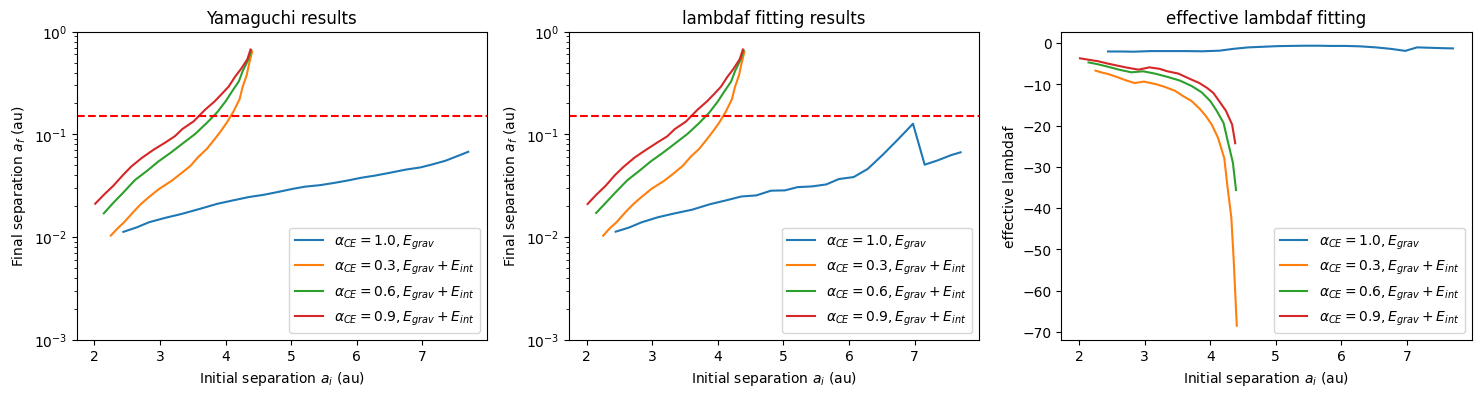

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
data = []
data.append(data1) # data[0] -- alpha = 1
data.append(data4) # data[1] -- alpha = 0.3
data.append(data3) # data[2] -- alpha = 0.6
data.append(data2) # data[3] -- alpha = 0.9

for i in range(len(x)):
    x_list = x[i]
    y_list = y[i]
    if i == 0: 
        axs[0].plot(x_list, y_list, label = r'$\alpha_{CE} = 1.0, E_{grav}$')
    elif i == 1: 
        axs[0].plot(x_list, y_list, label = r'$\alpha_{CE} = 0.3, E_{grav} + E_{int}$')
    elif i == 2: 
        axs[0].plot(x_list, y_list, label = r'$\alpha_{CE} = 0.6, E_{grav} + E_{int}$')
    elif i == 3: 
        axs[0].plot(x_list, y_list, label = r'$\alpha_{CE} = 0.9, E_{grav} + E_{int}$')

for i in range(len(x)):
    x_list = x[i]
    y_list = y[i]
    indexList = findNearestList(ai_list, x_list)
    res = []
    lambdaFitting = []
    for j in range(len(x_list)):
        resultCol = data[i][:, indexList[j]].tolist()
        lambdaIndex = findNearest(resultCol, y_list[j])
        res.append(data[i][lambdaIndex][indexList[j]])
        lambdaFitting.append(lambdaList[lambdaIndex])
    print(f'i = {i}')
    print(lambdaFitting)
    if i == 0: 
        axs[1].plot(x_list, res, label = r'$\alpha_{CE} = 1.0, E_{grav}$')
        axs[2].plot(x_list, lambdaFitting, label = r'$\alpha_{CE} = 1.0, E_{grav}$')
    elif i == 1: 
        axs[1].plot(x_list, res, label = r'$\alpha_{CE} = 0.3, E_{grav} + E_{int}$')
        axs[2].plot(x_list, lambdaFitting, label = r'$\alpha_{CE} = 0.3, E_{grav} + E_{int}$')
    elif i == 2: 
        axs[1].plot(x_list, res, label = r'$\alpha_{CE} = 0.6, E_{grav} + E_{int}$')
        axs[2].plot(x_list, lambdaFitting, label = r'$\alpha_{CE} = 0.6, E_{grav} + E_{int}$')
    elif i == 3: 
        axs[1].plot(x_list, res, label = r'$\alpha_{CE} = 0.9, E_{grav} + E_{int}$')
        axs[2].plot(x_list, lambdaFitting, label = r'$\alpha_{CE} = 0.9, E_{grav} + E_{int}$')

axs[0].set_xlabel('Initial separation $a_i$ (au)')
axs[0].set_ylabel('Final separation $a_f$ (au)')
axs[0].legend(loc='lower right')
axs[0].set_title('Yamaguchi results')
axs[0].axhline(y=0.15, color='red', linestyle='--')
axs[0].set_yscale('log')
axs[0].set_ylim(10**(-3), 1)

axs[1].set_xlabel('Initial separation $a_i$ (au)')
axs[1].set_ylabel('Final separation $a_f$ (au)')
axs[1].legend(loc='lower right')
axs[1].set_title('lambdaf fitting results')
axs[1].axhline(y=0.15, color='red', linestyle='--')
axs[1].set_yscale('log')
axs[1].set_ylim(10**(-3), 1)

axs[2].set_xlabel('Initial separation $a_i$ (au)')
axs[2].set_ylabel('effective lambdaf')
axs[2].legend(loc='lower right')
axs[2].set_title('effective lambdaf fitting')

# Display the plot
plt.savefig('7+1 fitting lambdaf.png', dpi=300)
plt.show()

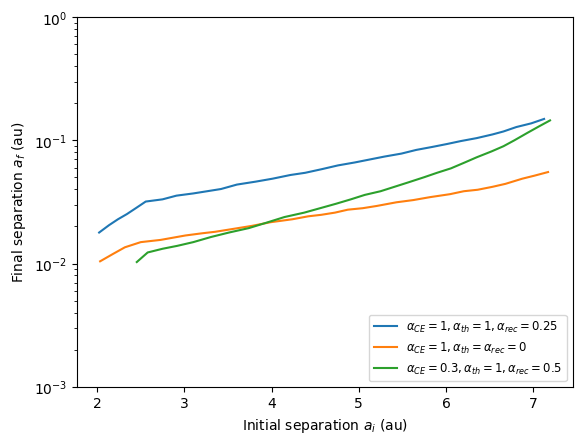

In [14]:
# Results in Yamaguchi 2023
x = [0, 0, 0]
y = [0, 0, 0]

x[0] = [2.022727272727273, 2.1363636363636362, 2.2386363636363638, 2.340909090909091, 2.4431818181818183, 2.5568181818181817, 2.75, 2.909090909090909, 3.1022727272727275, 3.2613636363636367, 3.4204545454545454, 3.6022727272727275, 3.8181818181818183, 4.011363636363637, 4.215909090909091, 4.386363636363637, 4.579545454545455, 4.761363636363637, 4.954545454545455, 5.125, 5.295454545454545, 5.488636363636363, 5.659090909090909, 5.840909090909091, 6.011363636363637, 6.170454545454546, 6.3522727272727275, 6.534090909090909, 6.659090909090909, 6.806818181818182, 6.9772727272727275, 7.125]
y[0] = [0.017844196867669127, 0.020482230324402606, 0.022870804266841148, 0.025188227360580816, 0.028125600028342537, 0.031841536185213286, 0.03318624261246709, 0.0355547970173894, 0.037056318922327865, 0.0386212519059432, 0.040252273894468595, 0.04372386682744838, 0.046203051395449966, 0.04882280807127712, 0.052307368781215904, 0.054516371970751105, 0.05840729130378811, 0.06257591167797887, 0.06612402500411511, 0.06987331970879666, 0.07383520296630267, 0.07802172874847364, 0.08359026241662165, 0.08832990928811921, 0.09333829861617868, 0.09863066835204767, 0.10422312045320946, 0.111661688715573, 0.11799301198561059, 0.1281694235747838, 0.1373170772073274, 0.14916010987823197]
plt.plot(x[0], y[0], label = r'$\alpha_{CE} = 1, \alpha_{th} = 1, \alpha_{rec} = 0.25$')

x[1] = [2.034090909090909, 2.1818181818181817, 2.3181818181818183, 2.5, 2.7272727272727275, 3.0113636363636367, 3.2045454545454546, 3.3522727272727275, 3.5113636363636367, 3.7727272727272725, 3.9886363636363638, 4.238636363636363, 4.420454545454545, 4.568181818181818, 4.7272727272727275, 4.875, 5.045454545454545, 5.204545454545455, 5.431818181818182, 5.625, 5.818181818181818, 6.045454545454546, 6.204545454545455, 6.363636363636363, 6.534090909090909, 6.681818181818182, 6.875, 7.011363636363637, 7.170454545454546]
y[1] = [0.010422312045320941, 0.011963115931086656, 0.013543675101108427, 0.014916010987823204, 0.01554593209865293, 0.016886704750447963, 0.017599850632637217, 0.018091935465728466, 0.018855979692763095, 0.020201760662364072, 0.021643592139424777, 0.022870804266841148, 0.024167600481592735, 0.02484331699177418, 0.025892480192909448, 0.027360608288141186, 0.028125600028342537, 0.029313377995727342, 0.031405519953034956, 0.03273181288960834, 0.03458773761188588, 0.03654889501975826, 0.0386212519059432, 0.039701086769011185, 0.04195217590618777, 0.04433090392471281, 0.04882280807127712, 0.05159110742628358, 0.055273246021372305]
plt.plot(x[1], y[1], label = r'$\alpha_{CE} = 1, \alpha_{th} = \alpha_{rec} = 0$')

x[2] = [2.4545454545454546, 2.5795454545454546, 2.75, 2.9204545454545454, 3.1022727272727275, 3.3068181818181817, 3.5113636363636367, 3.7386363636363638, 3.9318181818181817, 4.147727272727273, 4.375, 4.556818181818182, 4.738636363636363, 4.909090909090909, 5.068181818181818, 5.25, 5.409090909090909, 5.568181818181818, 5.75, 5.897727272727273, 6.056818181818182, 6.215909090909091, 6.3522727272727275, 6.5227272727272725, 6.659090909090909, 6.784090909090909, 6.931818181818182, 7.068181818181818, 7.193181818181818]
y[2] = [0.010279596028036015, 0.012297599900813274, 0.013175298974950124, 0.013922350877436438, 0.014916010987823204, 0.01642740113949234, 0.017844196867669127, 0.019383185395445514, 0.021347219582505912, 0.023836665879647594, 0.025892480192909448, 0.028125600028342537, 0.03055131725739149, 0.03318624261246709, 0.036048419433275844, 0.0386212519059432, 0.04195217590618777, 0.045570378390372396, 0.050187874392706465, 0.054516371970751105, 0.05921818464750933, 0.06612402500411511, 0.07282415416475525, 0.081316680333198, 0.08955623110333044, 0.1, 0.11478370518043987, 0.12994885436373793, 0.14510308524909035]
plt.plot(x[2], y[2], label = r'$\alpha_{CE} = 0.3, \alpha_{th} = 1, \alpha_{rec} = 0.5$')

plt.xlabel('Initial separation $a_i$ (au)')
plt.ylabel('Final separation $a_f$ (au)')
plt.legend(loc='lower right', fontsize='small')  # Add a legend to differentiate between lines

# Change y-axis to logarithmic scale
plt.yscale('log')
plt.ylim(10**(-3), 1)

# Display the plot
plt.savefig('7+1 energy budget yamaguchi result.png', dpi=300)
plt.show()

i = 0
[-2.9499999999999886, -3.0999999999999943, -3.25, -3.3499999999999943, -3.5, -3.6499999999999915, -3.549999999999997, -3.5999999999999943, -3.0999999999999943, -3.0999999999999943, -3.0999999999999943, -3.1499999999999915, -3.0999999999999943, -3.0999999999999943, -3.1499999999999915, -2.8499999999999943, -2.299999999999997, -2.0, -1.75, -1.5999999999999943, -1.5, -1.5, -1.5499999999999972, -1.5999999999999943, -1.5999999999999943, -1.6499999999999915, -1.6999999999999886, -1.75, -1.7999999999999972, -1.8999999999999915, -2.0, -3.0]
i = 1
[-2.1499999999999915, -2.1999999999999886, -2.299999999999997, -2.299999999999997, -2.25, -2.0, -2.0, -1.9499999999999886, -1.9499999999999886, -1.9499999999999886, -1.9499999999999886, -1.5, -1.1999999999999886, -1.0, -0.8499999999999943, -0.75, -0.6499999999999915, -0.6499999999999915, -0.5999999999999943, -0.5999999999999943, -0.5999999999999943, -0.5999999999999943, -0.6499999999999915, -0.7999999999999972, -1.0, -1.1999999999999886, -1.5999

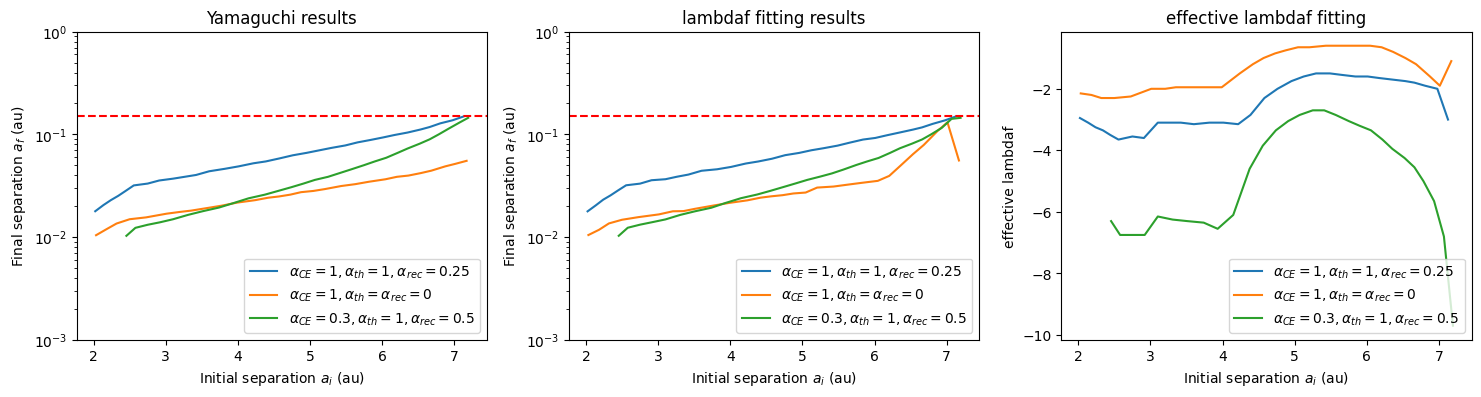

In [15]:
ig, axs = plt.subplots(1, 3, figsize=(18, 4))
data = []
data.append(data1)
data.append(data1)
data.append(data4)

for i in range(len(x)):
    x_list = x[i]
    y_list = y[i]
    if i == 0: 
        axs[0].plot(x_list, y_list, label = r'$\alpha_{CE} = 1, \alpha_{th} = 1, \alpha_{rec} = 0.25$')
    elif i == 1: 
        axs[0].plot(x_list, y_list, label = r'$\alpha_{CE} = 1, \alpha_{th} = \alpha_{rec} = 0$')
    elif i == 2: 
        axs[0].plot(x_list, y_list, label = r'$\alpha_{CE} = 0.3, \alpha_{th} = 1, \alpha_{rec} = 0.5$')

for i in range(len(x)):
    x_list = x[i]
    y_list = y[i]
    indexList = findNearestList(ai_list, x_list)
    res = []
    lambdaFitting = []
    for j in range(len(x_list)):
        resultCol = data[i][:, indexList[j]].tolist()
        lambdaIndex = findNearest(resultCol, y_list[j])
        res.append(data[i][lambdaIndex][indexList[j]])
        lambdaFitting.append(lambdaList[lambdaIndex])
    print(f'i = {i}')
    print(lambdaFitting)
    if i == 0: 
        axs[1].plot(x_list, res, label = r'$\alpha_{CE} = 1, \alpha_{th} = 1, \alpha_{rec} = 0.25$')
        axs[2].plot(x_list, lambdaFitting, label = r'$\alpha_{CE} = 1, \alpha_{th} = 1, \alpha_{rec} = 0.25$')
    elif i == 1: 
        axs[1].plot(x_list, res, label = r'$\alpha_{CE} = 1, \alpha_{th} = \alpha_{rec} = 0$')
        axs[2].plot(x_list, lambdaFitting, label = r'$\alpha_{CE} = 1, \alpha_{th} = \alpha_{rec} = 0$')
    elif i == 2: 
        axs[1].plot(x_list, res, label = r'$\alpha_{CE} = 0.3, \alpha_{th} = 1, \alpha_{rec} = 0.5$')
        axs[2].plot(x_list, lambdaFitting, label = r'$\alpha_{CE} = 0.3, \alpha_{th} = 1, \alpha_{rec} = 0.5$')

axs[0].set_xlabel('Initial separation $a_i$ (au)')
axs[0].set_ylabel('Final separation $a_f$ (au)')
axs[0].legend(loc='lower right')
axs[0].set_title('Yamaguchi results')
axs[0].axhline(y=0.15, color='red', linestyle='--')
axs[0].set_yscale('log')
axs[0].set_ylim(10**(-3), 1)

axs[1].set_xlabel('Initial separation $a_i$ (au)')
axs[1].set_ylabel('Final separation $a_f$ (au)')
axs[1].legend(loc='lower right')
axs[1].set_title('lambdaf fitting results')
axs[1].axhline(y=0.15, color='red', linestyle='--')
axs[1].set_yscale('log')
axs[1].set_ylim(10**(-3), 1)

axs[2].set_xlabel('Initial separation $a_i$ (au)')
axs[2].set_ylabel('effective lambdaf')
axs[2].legend(loc='lower right')
axs[2].set_title('effective lambdaf fitting')

# Display the plot
plt.savefig('7+1 energy budget fitting lambdaf.png', dpi=300)
plt.show()

In [16]:
# Results in Yamaguchi 2023
x = [0, 0, 0, 0]
y = [0, 0, 0, 0]

x[0] = [2.4404761904761902, 2.642857142857143, 2.833333333333333, 3.083333333333333, 3.321428571428571, 3.6071428571428568, 3.880952380952381, 4.142857142857142, 4.357142857142857, 4.583333333333333, 4.809523809523809, 5.023809523809524, 5.214285714285714, 5.44047619047619, 5.654761904761904, 5.845238095238095, 6.071428571428571, 6.285714285714286, 6.523809523809524, 6.75, 6.976190476190475, 7.154761904761904, 7.357142857142857, 7.559523809523809, 7.702380952380952]
y[0] = [0.011234183573687356, 0.012412601587602478, 0.013944544486216936, 0.015407267817255156, 0.016742747005726248, 0.018809109339013287, 0.02113049871720325, 0.022962059095951007, 0.024540968429645055, 0.025795998711377114, 0.027569774441469845, 0.02946551793779906, 0.0309723907160626, 0.03201954545586311, 0.03365703173802061, 0.035378259412695706, 0.03781092730903451, 0.03974458607597561, 0.04247748984810421, 0.0453983126241806, 0.047719991870304346, 0.0510012977955693, 0.05542201486227198, 0.06226210889863927, 0.06765889641805466]

x[1] = [2.25, 2.345238095238095, 2.452380952380952, 2.595238095238095, 2.714285714285714, 2.845238095238095, 2.988095238095238, 3.1785714285714284, 3.3095238095238093, 3.464285714285714, 3.583333333333333, 3.714285714285714, 3.833333333333333, 3.9285714285714284, 4.023809523809524, 4.119047619047619, 4.214285714285714, 4.261904761904762, 4.321428571428571, 4.357142857142857, 4.404761904761904]
y[1] = [0.010338092964602, 0.01200666470122069, 0.013944544486216936, 0.017598974605374764, 0.02113049871720325, 0.024952376419619688, 0.02946551793779906, 0.035378259412695706, 0.04108832256930621, 0.049333371222525825, 0.060225913146483526, 0.07231123454746669, 0.08975705447453801, 0.1077682857644978, 0.13156294122130663, 0.16604148409801042, 0.22027250401975687, 0.2922159862079623, 0.37497923628463475, 0.4811832147490381, 0.6383430754117011]

x[2] = [2.142857142857143, 2.2857142857142856, 2.4285714285714284, 2.619047619047619, 2.7976190476190474, 2.976190476190476, 3.1666666666666665, 3.3571428571428568, 3.5357142857142856, 3.714285714285714, 3.8690476190476186, 4, 4.095238095238095, 4.2023809523809526, 4.261904761904762, 4.345238095238095, 4.392857142857142]
y[2] = [0.017023424596426327, 0.021484733148877305, 0.026668143279297, 0.035971345159719274, 0.043913623895263904, 0.054508231767973085, 0.06654335495173698, 0.08259761533183257, 0.10083472270004161, 0.12939376725996599, 0.1633038373073242, 0.20955577752775972, 0.2601132376832342, 0.3282808032226341, 0.41431296124858524, 0.5316572847635216, 0.659925005691611]

x[3] = [2.011904761904762, 2.142857142857143, 2.2857142857142856, 2.4285714285714284, 2.5595238095238093, 2.726190476190476, 2.9047619047619047, 3.071428571428571, 3.226190476190476, 3.345238095238095, 3.511904761904762, 3.6904761904761902, 3.833333333333333, 3.952380952380952, 4.0476190476190474, 4.142857142857142, 4.238095238095238, 4.333333333333333, 4.3809523809523805]
y[3] = [0.02113049871720325, 0.025795998711377114, 0.03149161590661423, 0.03974458607597561, 0.0485199760271338, 0.05923292468497171, 0.07111898659651138, 0.08259761533183257, 0.09592889866684408, 0.11327957854141268, 0.13376847949736032, 0.17453288048133356, 0.20955577752775972, 0.25160659569794086, 0.2922159862079623, 0.3627160614327777, 0.4355010131370727, 0.5405700567067716, 0.6709880744088835]

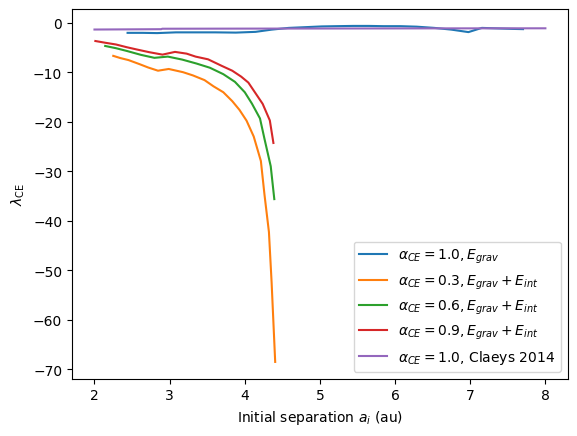

In [17]:
fitting = [0, 0, 0, 0]
fitting[0] = [-2.0, -2.0, -2.049999999999997, -1.8999999999999915, -1.8999999999999915, -1.8999999999999915, -1.9499999999999886, -1.7999999999999972, -1.3499999999999943, -1.0, -0.8499999999999943, -0.6999999999999886, -0.6499999999999915, -0.5999999999999943, -0.5999999999999943, -0.6499999999999915, -0.6499999999999915, -0.75, -1.0, -1.3499999999999943, -1.8499999999999943, -1.0, -1.0999999999999943, -1.1999999999999886, -1.25]
fitting[1] = [-6.6499999999999915, -7.099999999999994, -7.5, -8.299999999999997, -9.0, -9.649999999999991, -9.299999999999997, -9.949999999999989, -10.599999999999994, -11.549999999999997, -12.799999999999997, -14.0, -15.799999999999997, -17.549999999999997, -19.75, -22.94999999999999, -27.89999999999999, -34.64999999999999, -42.25, -52.449999999999996, -68.5]
fitting[2] = [-4.6499999999999915, -5.099999999999994, -5.6499999999999915, -6.449999999999989, -7.049999999999997, -6.799999999999997, -7.3999999999999915, -8.199999999999989, -9.049999999999997, -10.349999999999994, -11.899999999999991, -14.0, -16.299999999999997, -19.299999999999997, -23.39999999999999, -28.950000000000003, -35.599999999999994]
fitting[3] = [-3.6499999999999915, -4.0, -4.349999999999994, -4.8999999999999915, -5.349999999999994, -5.8999999999999915, -6.3999999999999915, -5.849999999999994, -6.199999999999989, -6.799999999999997, -7.349999999999994, -8.649999999999991, -9.649999999999991, -10.849999999999994, -12.049999999999997, -14.199999999999989, -16.349999999999994, -19.69999999999999, -24.25]

for i in range(len(x)):
    x_list = x[i]
    y_list = y[i]
    if i == 0: 
        plt.plot(x_list, fitting[i], label = r'$\alpha_{CE} = 1.0, E_{grav}$')
    elif i == 1: 
        plt.plot(x_list, fitting[i], label = r'$\alpha_{CE} = 0.3, E_{grav} + E_{int}$')
    elif i == 2: 
        plt.plot(x_list, fitting[i], label = r'$\alpha_{CE} = 0.6, E_{grav} + E_{int}$')
    elif i == 3: 
        plt.plot(x_list, fitting[i], label = r'$\alpha_{CE} = 0.9, E_{grav} + E_{int}$')

ai_list = np.linspace(SEP_START, SEP_END, NUM_SEP).tolist()
default = [1.328838983810069, 1.327462414508864, 1.3260935298603327, 1.3247315610302717, 1.3233701062095748, 1.3220225858629522, 1.3206913912102083, 1.3193731487631788, 1.3180606184665251, 1.3167532257142252, 1.315448277641708, 1.3141570429378366, 1.3128834176687973, 1.3116138139923486, 1.3103472784116692, 1.3091304353780235, 1.3078416051367825, 1.3066062169918713, 1.3053727994751472, 1.3041398749473454, 1.3029288552397194, 1.301724197256633, 1.3005200148588592, 1.299307619160248, 1.298137727257229, 1.2969600883717864, 1.2957810045635965, 1.294612841639015, 1.293459790180403, 1.292305047054243, 1.2911218178834156, 1.290018367619541, 1.2888859040528517, 1.2877490938449225, 1.2866341887430808, 1.2855221546375533, 1.2844050876200546, 1.2833053240570889, 1.2822119997602621, 1.2811127416891313, 1.2800297198423989, 1.278953341030155, 1.277869924044111, 1.276805079077957, 1.2757438296684347, 1.2746742306173362, 1.2736289162308683, 1.272581039699659, 1.2714753987341383, 1.2704992779336537, 1.2694632239821992, 1.2684310627973017, 1.2674149935073908, 1.2663885266472943, 1.2653801705048873, 1.2643735749106735, 1.263359239057532, 1.2623716270822944, 1.2613723653312692, 1.260384053554506, 1.1683724022943616, 1.168390497259502, 1.1684270240200982, 1.1685136580085902, 1.1759531800998495, 1.1754131679559368, 1.174877264692757, 1.1743339434730453, 1.1737790389696836, 1.1732811771066676, 1.1727608478194886, 1.1722357521135867, 1.1717103200136938, 1.1712020025757934, 1.1706933661644943, 1.170184584741796, 1.169654594729964, 1.1691675996661508, 1.168662501274583, 1.1681697547373326, 1.167640179173169, 1.1671793274829287, 1.1666893689893256, 1.166203632401833, 1.1657155760643612, 1.1652381359440815, 1.1647577062632828, 1.1642830490841098, 1.1638072509164112, 1.1633321716470664, 1.1628695280420787, 1.1624017069798391, 1.1619389818153838, 1.1614716778279943, 1.1610152754298317, 1.1605623375895382, 1.160106969230652, 1.1596507002042888, 1.1592023573015537, 1.1587568634443848, 1.1583101551780701, 1.1578646479747645, 1.1574346834711713, 1.156986018846219, 1.1565499871218172, 1.1561132909936094, 1.1556773657335366, 1.155246881143304, 1.1548201966090081, 1.1543941544931169, 1.1539685146459997, 1.1535060439529978, 1.153122566775785, 1.1527030003995196, 1.1522855572675055, 1.1518692502445775, 1.1514587881384033, 1.1510441311146602, 1.1506349626157244, 1.150226457298439, 1.1498183154849757, 1.1494372163609223, 1.1490101749439412, 1.148608371571962, 1.1482084923717788, 1.14780898512775, 1.1474392944791836, 1.1470192522094576, 1.1466271406973019, 1.1462353358341324, 1.1458439683859192, 1.145476865524361, 1.1450701611837344, 1.1446861739294332, 1.1443025219513454, 1.1439192720127307, 1.1435488217748668, 1.1431608320758966, 1.142784791423547, 1.1424091166138075, 1.1420337103854623, 1.1416429197128752, 1.1412895252757704, 1.1409211951259257, 1.1405532816764938, 1.1401854731331778, 1.1398180375718803, 1.1394543848363448, 1.1390936240521126, 1.1387331735168487, 1.1383727558498768, 1.1380125700617856, 1.1376651035779495, 1.1373002769298728, 1.1369469959333331, 1.1365937189482906, 1.1362405547718772, 1.1358881949414146, 1.135540036786306, 1.1351942965069481, 1.1348486279086756, 1.1345029833672169, 1.1341574758282655, 1.133819960456084, 1.1334738349713942, 1.133135054054633, 1.1327964769154741, 1.132458670548461, 1.1321209152522131, 1.131785707947461, 1.1314544681527392, 1.1311233707813124, 1.1307924556862345, 1.1304614108926951, 1.1301305702306048, 1.1298030807123935, 1.1294787049970179, 1.129154572065652, 1.1288302853961607, 1.1285058879270153, 1.1281816991216762, 1.1278610585295445, 1.127543572150012, 1.1272258887609699, 1.1269080672113487, 1.1265902098300313, 1.1262724972449474, 1.1259581357369515, 1.1256468751331092, 1.1253354888325098, 1.1250240320319511, 1.124712561751237, 1.1244007713084092, 1.1240917494366207, 1.123786401466787, 1.1234809358801956, 1.1231754219099663, 1.1228700490441232, 1.1225644255343423, 1.1222819692118002, 1.1219609821311227, 1.1216617496067558, 1.1213625464847046, 1.1210631474128339, 1.120763464088712, 1.120438046646065, 1.1201694361510346, 1.1198760744714602, 1.1195828884648749, 1.1192893602186844, 1.1189955593379577, 1.1187016954934883, 1.11844184246254, 1.1181223055361351, 1.1178348496398043, 1.117547058359993, 1.1172589977178022, 1.1169707275133216, 1.1166825633839963, 1.1163986808092015, 1.116116827191256, 1.115834637191409, 1.1155521739201162, 1.115269452104957, 1.1149865620371768, 1.1147055869646119, 1.1144272679985878, 1.1141505499048354, 1.1138735182922719, 1.1135962384168585, 1.1133187394170156, 1.1130408879314828, 1.1127954758479321, 1.112493326226013, 1.1122216120107888, 1.111949658002339, 1.1116775297941572, 1.1114050119920498, 1.111132213983177, 1.110861604319393, 1.1105951298029377, 1.1103283977804104, 1.1100615530872433, 1.1097944182231552, 1.1095268043549296, 1.109258901980153, 1.1090255487568095, 1.1087312617173568, 1.1084695769959785, 1.1082077705974058, 1.107945444325081, 1.1076826681629792, 1.1074196349108174, 1.1071657269816713, 1.1069004651771386, 1.1066439527793273, 1.1063868804174142, 1.10612935426728, 1.1058714395555644, 1.1056132251212891, 1.105322701919793, 1.1051019173148622, 1.1048500888626853, 1.1045977894758678, 1.104345075782264, 1.1040920021873775, 1.1038386210675666, 1.103585021440895, 1.1033340921239798, 1.1030870123804108, 1.1028394887424366, 1.1025915751990427, 1.1023433236535003, 1.102094769445493, 1.1018457020401906, 1.1015893413156588, 1.1013537500313464, 1.1011109956911946, 1.1008678689994316, 1.1006244098124718, 1.1003806123557989, 1.1001363481053725, 1.0998917330628275, 1.0996493431611378, 1.09941134921225, 1.0991729938499928, 1.098934253501032, 1.0986953079382396, 1.098455934445804, 1.0982160249317663, 1.0979759449768647, 1.097739587280782, 1.0975059326802614, 1.0972719440952567, 1.0970378727647043, 1.0968033967759792, 1.0965683870161804, 1.0963329195778222, 1.096097319464778, 1.095865762912304, 1.0956365035568563, 1.0954072781379267, 1.0951777039819515, 1.0949475963506279, 1.0947170054428246, 1.0944859277294263, 1.0942547488129082, 1.0940269373244051, 1.0938024652849072, 1.0935777976149001, 1.0933525906486574, 1.0931268691299514, 1.0929006439891764, 1.0926740207354684, 1.0924472724324779, 1.092254161021195, 1.0920025946957568, 1.0917822912529578, 1.0915614329407717, 1.0913400825143658, 1.0911183185103872, 1.0908961845451144, 1.0906738222982577, 1.0904499311912008, 1.0902356044742278, 1.0900196243253832, 1.0898031508396429, 1.0895862442462847, 1.089368946943123, 1.0891513003523103, 1.088933228349273, 1.088714788365404, 1.0885003562902793, 1.0882887766202067, 1.0880767407064185, 1.0878741204306128, 1.0877014003504923, 1.087547633103462, 1.0874080215942818, 1.0873196059532493, 1.0873156704806022, 1.0873100034532934, 1.0873020764170263, 1.0872915346855174, 1.0872805912461265, 1.087269303514777, 1.0872575934206197, 1.0872423132421525, 1.0872252943327907, 1.0872104823999802, 1.0871935501544279, 1.0871748988125285, 1.0871543744257561, 1.0871218399636233, 1.087075105340233, 1.0870229889390726, 1.0869698800871692, 1.0868771355530789, 1.086764170601517, 1.086627641655947, 1.0864925130305454, 1.086333980140532, 1.0861710302478704, 1.0860051195910558, 1.085837440002665, 1.0856703770902543, 1.0855032847799193, 1.085305900235371, 1.0851682061269137, 1.0850011282186554, 1.0848331224166468, 1.0846661773164001, 1.0844995448744275, 1.0843320987972436, 1.0841857287771446, 1.0839985741082967, 1.083831652858291, 1.0836641033347527, 1.083497705416709, 1.0833316509297557, 1.0831649755634567, 1.0829780019684492, 1.0828321340699882, 1.0826665346931574, 1.082500463663573, 1.0823267535035095, 1.0821694116865308, 1.0820044862472835, 1.0818390097133492, 1.0816935144964734, 1.0815096204106003, 1.081345163559763, 1.0811800302894534, 1.0810156604293044, 1.0808521303175311, 1.0806880189348704, 1.0805033760269698, 1.0803601668171265, 1.0801973669765568, 1.0800339731227362]
for i in range(len(default)):
    default[i] *= -1
plt.plot(ai_list, default, label = r'$\alpha_{CE} = 1.0$, Claeys 2014')

plt.xlabel('Initial separation $a_i$ (au)')
plt.ylabel(r'$\lambda_{\mathrm{CE}}$')
plt.legend(loc='lower right')

# Display the plot
plt.savefig('7+1 lambdaf comparison.png', dpi=300)
plt.show()

i = 0
[-2.0, -2.0, -2.049999999999997, -1.8999999999999915, -1.8999999999999915, -1.8999999999999915, -1.9499999999999886, -1.7999999999999972, -1.3499999999999943, -1.0, -0.8499999999999943, -0.6999999999999886, -0.6499999999999915, -0.5999999999999943, -0.5999999999999943, -0.6499999999999915, -0.6499999999999915, -0.75, -1.0, -1.3499999999999943, -1.8499999999999943, -1.0, -1.0999999999999943, -1.1999999999999886, -1.25]
i = 1
[-6.6499999999999915, -7.099999999999994, -7.5, -8.299999999999997, -9.0, -9.649999999999991, -9.299999999999997, -9.949999999999989, -10.599999999999994, -11.549999999999997, -12.799999999999997, -14.0, -15.799999999999997, -17.549999999999997, -19.75, -22.94999999999999, -27.89999999999999, -34.64999999999999, -42.25, -52.449999999999996, -68.5]
i = 2
[-4.6499999999999915, -5.099999999999994, -5.6499999999999915, -6.449999999999989, -7.049999999999997, -6.799999999999997, -7.3999999999999915, -8.199999999999989, -9.049999999999997, -10.349999999999994, -11.8

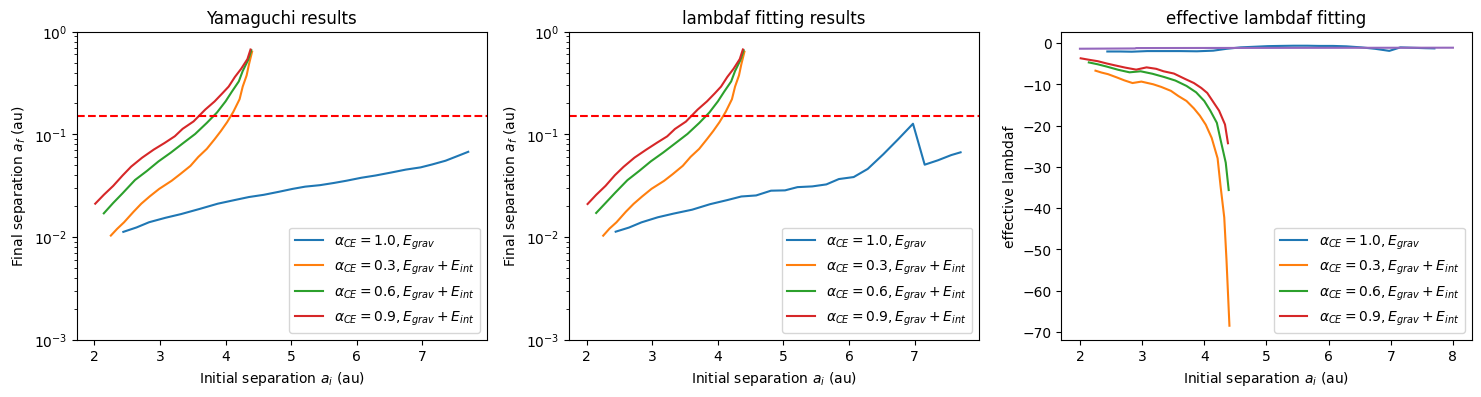

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
data = []
data.append(data1) # data[0] -- alpha = 1
data.append(data4) # data[1] -- alpha = 0.3
data.append(data3) # data[2] -- alpha = 0.6
data.append(data2) # data[3] -- alpha = 0.9

for i in range(len(x)):
    x_list = x[i]
    y_list = y[i]
    if i == 0: 
        axs[0].plot(x_list, y_list, label = r'$\alpha_{CE} = 1.0, E_{grav}$')
    elif i == 1: 
        axs[0].plot(x_list, y_list, label = r'$\alpha_{CE} = 0.3, E_{grav} + E_{int}$')
    elif i == 2: 
        axs[0].plot(x_list, y_list, label = r'$\alpha_{CE} = 0.6, E_{grav} + E_{int}$')
    elif i == 3: 
        axs[0].plot(x_list, y_list, label = r'$\alpha_{CE} = 0.9, E_{grav} + E_{int}$')

for i in range(len(x)):
    x_list = x[i]
    y_list = y[i]
    indexList = findNearestList(ai_list, x_list)
    res = []
    lambdaFitting = []
    for j in range(len(x_list)):
        resultCol = data[i][:, indexList[j]].tolist()
        lambdaIndex = findNearest(resultCol, y_list[j])
        res.append(data[i][lambdaIndex][indexList[j]])
        lambdaFitting.append(lambdaList[lambdaIndex])
    print(f'i = {i}')
    print(lambdaFitting)
    if i == 0: 
        axs[1].plot(x_list, res, label = r'$\alpha_{CE} = 1.0, E_{grav}$')
        axs[2].plot(x_list, lambdaFitting, label = r'$\alpha_{CE} = 1.0, E_{grav}$')
    elif i == 1: 
        axs[1].plot(x_list, res, label = r'$\alpha_{CE} = 0.3, E_{grav} + E_{int}$')
        axs[2].plot(x_list, lambdaFitting, label = r'$\alpha_{CE} = 0.3, E_{grav} + E_{int}$')
    elif i == 2: 
        axs[1].plot(x_list, res, label = r'$\alpha_{CE} = 0.6, E_{grav} + E_{int}$')
        axs[2].plot(x_list, lambdaFitting, label = r'$\alpha_{CE} = 0.6, E_{grav} + E_{int}$')
    elif i == 3: 
        axs[1].plot(x_list, res, label = r'$\alpha_{CE} = 0.9, E_{grav} + E_{int}$')
        axs[2].plot(x_list, lambdaFitting, label = r'$\alpha_{CE} = 0.9, E_{grav} + E_{int}$')

axs[0].set_xlabel('Initial separation $a_i$ (au)')
axs[0].set_ylabel('Final separation $a_f$ (au)')
axs[0].legend(loc='lower right')
axs[0].set_title('Yamaguchi results')
axs[0].axhline(y=0.15, color='red', linestyle='--')
axs[0].set_yscale('log')
axs[0].set_ylim(10**(-3), 1)

axs[1].set_xlabel('Initial separation $a_i$ (au)')
axs[1].set_ylabel('Final separation $a_f$ (au)')
axs[1].legend(loc='lower right')
axs[1].set_title('lambdaf fitting results')
axs[1].axhline(y=0.15, color='red', linestyle='--')
axs[1].set_yscale('log')
axs[1].set_ylim(10**(-3), 1)

axs[2].set_xlabel('Initial separation $a_i$ (au)')
axs[2].set_ylabel('effective lambdaf')
axs[2].legend(loc='lower right')
axs[2].set_title('effective lambdaf fitting')
axs[2].plot(ai_list, default, label = r'$\alpha_{CE} = 1.0$, Claeys 2014')

# Display the plot
plt.savefig('7+1 fitting lambdaf cmp.png', dpi=300)
plt.show()

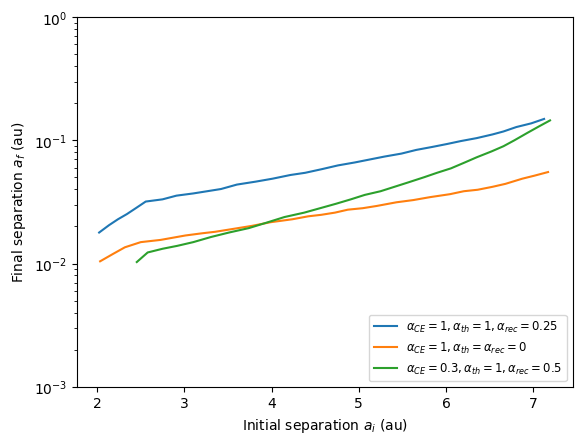

In [19]:
# Results in Yamaguchi 2023
x = [0, 0, 0]
y = [0, 0, 0]

x[0] = [2.022727272727273, 2.1363636363636362, 2.2386363636363638, 2.340909090909091, 2.4431818181818183, 2.5568181818181817, 2.75, 2.909090909090909, 3.1022727272727275, 3.2613636363636367, 3.4204545454545454, 3.6022727272727275, 3.8181818181818183, 4.011363636363637, 4.215909090909091, 4.386363636363637, 4.579545454545455, 4.761363636363637, 4.954545454545455, 5.125, 5.295454545454545, 5.488636363636363, 5.659090909090909, 5.840909090909091, 6.011363636363637, 6.170454545454546, 6.3522727272727275, 6.534090909090909, 6.659090909090909, 6.806818181818182, 6.9772727272727275, 7.125]
y[0] = [0.017844196867669127, 0.020482230324402606, 0.022870804266841148, 0.025188227360580816, 0.028125600028342537, 0.031841536185213286, 0.03318624261246709, 0.0355547970173894, 0.037056318922327865, 0.0386212519059432, 0.040252273894468595, 0.04372386682744838, 0.046203051395449966, 0.04882280807127712, 0.052307368781215904, 0.054516371970751105, 0.05840729130378811, 0.06257591167797887, 0.06612402500411511, 0.06987331970879666, 0.07383520296630267, 0.07802172874847364, 0.08359026241662165, 0.08832990928811921, 0.09333829861617868, 0.09863066835204767, 0.10422312045320946, 0.111661688715573, 0.11799301198561059, 0.1281694235747838, 0.1373170772073274, 0.14916010987823197]
plt.plot(x[0], y[0], label = r'$\alpha_{CE} = 1, \alpha_{th} = 1, \alpha_{rec} = 0.25$')

x[1] = [2.034090909090909, 2.1818181818181817, 2.3181818181818183, 2.5, 2.7272727272727275, 3.0113636363636367, 3.2045454545454546, 3.3522727272727275, 3.5113636363636367, 3.7727272727272725, 3.9886363636363638, 4.238636363636363, 4.420454545454545, 4.568181818181818, 4.7272727272727275, 4.875, 5.045454545454545, 5.204545454545455, 5.431818181818182, 5.625, 5.818181818181818, 6.045454545454546, 6.204545454545455, 6.363636363636363, 6.534090909090909, 6.681818181818182, 6.875, 7.011363636363637, 7.170454545454546]
y[1] = [0.010422312045320941, 0.011963115931086656, 0.013543675101108427, 0.014916010987823204, 0.01554593209865293, 0.016886704750447963, 0.017599850632637217, 0.018091935465728466, 0.018855979692763095, 0.020201760662364072, 0.021643592139424777, 0.022870804266841148, 0.024167600481592735, 0.02484331699177418, 0.025892480192909448, 0.027360608288141186, 0.028125600028342537, 0.029313377995727342, 0.031405519953034956, 0.03273181288960834, 0.03458773761188588, 0.03654889501975826, 0.0386212519059432, 0.039701086769011185, 0.04195217590618777, 0.04433090392471281, 0.04882280807127712, 0.05159110742628358, 0.055273246021372305]
plt.plot(x[1], y[1], label = r'$\alpha_{CE} = 1, \alpha_{th} = \alpha_{rec} = 0$')

x[2] = [2.4545454545454546, 2.5795454545454546, 2.75, 2.9204545454545454, 3.1022727272727275, 3.3068181818181817, 3.5113636363636367, 3.7386363636363638, 3.9318181818181817, 4.147727272727273, 4.375, 4.556818181818182, 4.738636363636363, 4.909090909090909, 5.068181818181818, 5.25, 5.409090909090909, 5.568181818181818, 5.75, 5.897727272727273, 6.056818181818182, 6.215909090909091, 6.3522727272727275, 6.5227272727272725, 6.659090909090909, 6.784090909090909, 6.931818181818182, 7.068181818181818, 7.193181818181818]
y[2] = [0.010279596028036015, 0.012297599900813274, 0.013175298974950124, 0.013922350877436438, 0.014916010987823204, 0.01642740113949234, 0.017844196867669127, 0.019383185395445514, 0.021347219582505912, 0.023836665879647594, 0.025892480192909448, 0.028125600028342537, 0.03055131725739149, 0.03318624261246709, 0.036048419433275844, 0.0386212519059432, 0.04195217590618777, 0.045570378390372396, 0.050187874392706465, 0.054516371970751105, 0.05921818464750933, 0.06612402500411511, 0.07282415416475525, 0.081316680333198, 0.08955623110333044, 0.1, 0.11478370518043987, 0.12994885436373793, 0.14510308524909035]
plt.plot(x[2], y[2], label = r'$\alpha_{CE} = 0.3, \alpha_{th} = 1, \alpha_{rec} = 0.5$')

plt.xlabel('Initial separation $a_i$ (au)')
plt.ylabel('Final separation $a_f$ (au)')
plt.legend(loc='lower right', fontsize='small')  # Add a legend to differentiate between lines

# Change y-axis to logarithmic scale
plt.yscale('log')
plt.ylim(10**(-3), 1)

# Display the plot
plt.savefig('7+1 energy budget yamaguchi result.png', dpi=300)
plt.show()

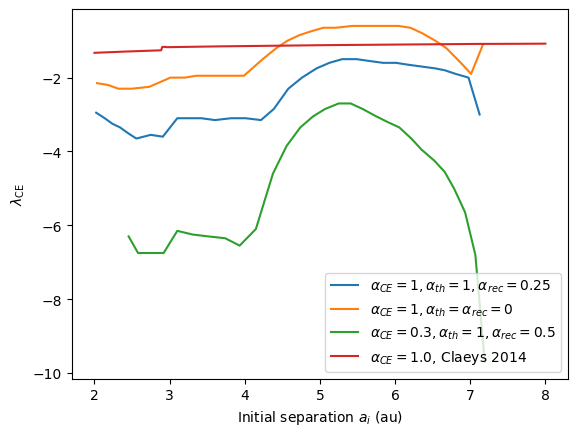

In [20]:
fitting = [0, 0, 0]
fitting[0] = [-2.9499999999999886, -3.0999999999999943, -3.25, -3.3499999999999943, -3.5, -3.6499999999999915, -3.549999999999997, -3.5999999999999943, -3.0999999999999943, -3.0999999999999943, -3.0999999999999943, -3.1499999999999915, -3.0999999999999943, -3.0999999999999943, -3.1499999999999915, -2.8499999999999943, -2.299999999999997, -2.0, -1.75, -1.5999999999999943, -1.5, -1.5, -1.5499999999999972, -1.5999999999999943, -1.5999999999999943, -1.6499999999999915, -1.6999999999999886, -1.75, -1.7999999999999972, -1.8999999999999915, -2.0, -3.0]
fitting[1] = [-2.1499999999999915, -2.1999999999999886, -2.299999999999997, -2.299999999999997, -2.25, -2.0, -2.0, -1.9499999999999886, -1.9499999999999886, -1.9499999999999886, -1.9499999999999886, -1.5, -1.1999999999999886, -1.0, -0.8499999999999943, -0.75, -0.6499999999999915, -0.6499999999999915, -0.5999999999999943, -0.5999999999999943, -0.5999999999999943, -0.5999999999999943, -0.6499999999999915, -0.7999999999999972, -1.0, -1.1999999999999886, -1.5999999999999943, -1.8999999999999915, -1.0999999999999943]
fitting[2] = [-6.299999999999997, -6.75, -6.75, -6.75, -6.1499999999999915, -6.25, -6.299999999999997, -6.349999999999994, -6.549999999999997, -6.099999999999994, -4.599999999999994, -3.8499999999999943, -3.3499999999999943, -3.049999999999997, -2.8499999999999943, -2.6999999999999886, -2.6999999999999886, -2.8499999999999943, -3.049999999999997, -3.1999999999999886, -3.3499999999999943, -3.6499999999999915, -3.9499999999999886, -4.25, -4.549999999999997, -5.0, -5.6499999999999915, -6.799999999999997, -9.699999999999989]

for i in range(3):
    x_list = x[i]
    y_list = y[i]
    if i == 0: 
        plt.plot(x_list, fitting[i], label = r'$\alpha_{CE} = 1, \alpha_{th} = 1, \alpha_{rec} = 0.25$')
    elif i == 1: 
        plt.plot(x_list, fitting[i], label = r'$\alpha_{CE} = 1, \alpha_{th} = \alpha_{rec} = 0$')
    elif i == 2: 
        plt.plot(x_list, fitting[i], label = r'$\alpha_{CE} = 0.3, \alpha_{th} = 1, \alpha_{rec} = 0.5$')

ai_list = np.linspace(SEP_START, SEP_END, NUM_SEP).tolist()
default = [1.328838983810069, 1.327462414508864, 1.3260935298603327, 1.3247315610302717, 1.3233701062095748, 1.3220225858629522, 1.3206913912102083, 1.3193731487631788, 1.3180606184665251, 1.3167532257142252, 1.315448277641708, 1.3141570429378366, 1.3128834176687973, 1.3116138139923486, 1.3103472784116692, 1.3091304353780235, 1.3078416051367825, 1.3066062169918713, 1.3053727994751472, 1.3041398749473454, 1.3029288552397194, 1.301724197256633, 1.3005200148588592, 1.299307619160248, 1.298137727257229, 1.2969600883717864, 1.2957810045635965, 1.294612841639015, 1.293459790180403, 1.292305047054243, 1.2911218178834156, 1.290018367619541, 1.2888859040528517, 1.2877490938449225, 1.2866341887430808, 1.2855221546375533, 1.2844050876200546, 1.2833053240570889, 1.2822119997602621, 1.2811127416891313, 1.2800297198423989, 1.278953341030155, 1.277869924044111, 1.276805079077957, 1.2757438296684347, 1.2746742306173362, 1.2736289162308683, 1.272581039699659, 1.2714753987341383, 1.2704992779336537, 1.2694632239821992, 1.2684310627973017, 1.2674149935073908, 1.2663885266472943, 1.2653801705048873, 1.2643735749106735, 1.263359239057532, 1.2623716270822944, 1.2613723653312692, 1.260384053554506, 1.1683724022943616, 1.168390497259502, 1.1684270240200982, 1.1685136580085902, 1.1759531800998495, 1.1754131679559368, 1.174877264692757, 1.1743339434730453, 1.1737790389696836, 1.1732811771066676, 1.1727608478194886, 1.1722357521135867, 1.1717103200136938, 1.1712020025757934, 1.1706933661644943, 1.170184584741796, 1.169654594729964, 1.1691675996661508, 1.168662501274583, 1.1681697547373326, 1.167640179173169, 1.1671793274829287, 1.1666893689893256, 1.166203632401833, 1.1657155760643612, 1.1652381359440815, 1.1647577062632828, 1.1642830490841098, 1.1638072509164112, 1.1633321716470664, 1.1628695280420787, 1.1624017069798391, 1.1619389818153838, 1.1614716778279943, 1.1610152754298317, 1.1605623375895382, 1.160106969230652, 1.1596507002042888, 1.1592023573015537, 1.1587568634443848, 1.1583101551780701, 1.1578646479747645, 1.1574346834711713, 1.156986018846219, 1.1565499871218172, 1.1561132909936094, 1.1556773657335366, 1.155246881143304, 1.1548201966090081, 1.1543941544931169, 1.1539685146459997, 1.1535060439529978, 1.153122566775785, 1.1527030003995196, 1.1522855572675055, 1.1518692502445775, 1.1514587881384033, 1.1510441311146602, 1.1506349626157244, 1.150226457298439, 1.1498183154849757, 1.1494372163609223, 1.1490101749439412, 1.148608371571962, 1.1482084923717788, 1.14780898512775, 1.1474392944791836, 1.1470192522094576, 1.1466271406973019, 1.1462353358341324, 1.1458439683859192, 1.145476865524361, 1.1450701611837344, 1.1446861739294332, 1.1443025219513454, 1.1439192720127307, 1.1435488217748668, 1.1431608320758966, 1.142784791423547, 1.1424091166138075, 1.1420337103854623, 1.1416429197128752, 1.1412895252757704, 1.1409211951259257, 1.1405532816764938, 1.1401854731331778, 1.1398180375718803, 1.1394543848363448, 1.1390936240521126, 1.1387331735168487, 1.1383727558498768, 1.1380125700617856, 1.1376651035779495, 1.1373002769298728, 1.1369469959333331, 1.1365937189482906, 1.1362405547718772, 1.1358881949414146, 1.135540036786306, 1.1351942965069481, 1.1348486279086756, 1.1345029833672169, 1.1341574758282655, 1.133819960456084, 1.1334738349713942, 1.133135054054633, 1.1327964769154741, 1.132458670548461, 1.1321209152522131, 1.131785707947461, 1.1314544681527392, 1.1311233707813124, 1.1307924556862345, 1.1304614108926951, 1.1301305702306048, 1.1298030807123935, 1.1294787049970179, 1.129154572065652, 1.1288302853961607, 1.1285058879270153, 1.1281816991216762, 1.1278610585295445, 1.127543572150012, 1.1272258887609699, 1.1269080672113487, 1.1265902098300313, 1.1262724972449474, 1.1259581357369515, 1.1256468751331092, 1.1253354888325098, 1.1250240320319511, 1.124712561751237, 1.1244007713084092, 1.1240917494366207, 1.123786401466787, 1.1234809358801956, 1.1231754219099663, 1.1228700490441232, 1.1225644255343423, 1.1222819692118002, 1.1219609821311227, 1.1216617496067558, 1.1213625464847046, 1.1210631474128339, 1.120763464088712, 1.120438046646065, 1.1201694361510346, 1.1198760744714602, 1.1195828884648749, 1.1192893602186844, 1.1189955593379577, 1.1187016954934883, 1.11844184246254, 1.1181223055361351, 1.1178348496398043, 1.117547058359993, 1.1172589977178022, 1.1169707275133216, 1.1166825633839963, 1.1163986808092015, 1.116116827191256, 1.115834637191409, 1.1155521739201162, 1.115269452104957, 1.1149865620371768, 1.1147055869646119, 1.1144272679985878, 1.1141505499048354, 1.1138735182922719, 1.1135962384168585, 1.1133187394170156, 1.1130408879314828, 1.1127954758479321, 1.112493326226013, 1.1122216120107888, 1.111949658002339, 1.1116775297941572, 1.1114050119920498, 1.111132213983177, 1.110861604319393, 1.1105951298029377, 1.1103283977804104, 1.1100615530872433, 1.1097944182231552, 1.1095268043549296, 1.109258901980153, 1.1090255487568095, 1.1087312617173568, 1.1084695769959785, 1.1082077705974058, 1.107945444325081, 1.1076826681629792, 1.1074196349108174, 1.1071657269816713, 1.1069004651771386, 1.1066439527793273, 1.1063868804174142, 1.10612935426728, 1.1058714395555644, 1.1056132251212891, 1.105322701919793, 1.1051019173148622, 1.1048500888626853, 1.1045977894758678, 1.104345075782264, 1.1040920021873775, 1.1038386210675666, 1.103585021440895, 1.1033340921239798, 1.1030870123804108, 1.1028394887424366, 1.1025915751990427, 1.1023433236535003, 1.102094769445493, 1.1018457020401906, 1.1015893413156588, 1.1013537500313464, 1.1011109956911946, 1.1008678689994316, 1.1006244098124718, 1.1003806123557989, 1.1001363481053725, 1.0998917330628275, 1.0996493431611378, 1.09941134921225, 1.0991729938499928, 1.098934253501032, 1.0986953079382396, 1.098455934445804, 1.0982160249317663, 1.0979759449768647, 1.097739587280782, 1.0975059326802614, 1.0972719440952567, 1.0970378727647043, 1.0968033967759792, 1.0965683870161804, 1.0963329195778222, 1.096097319464778, 1.095865762912304, 1.0956365035568563, 1.0954072781379267, 1.0951777039819515, 1.0949475963506279, 1.0947170054428246, 1.0944859277294263, 1.0942547488129082, 1.0940269373244051, 1.0938024652849072, 1.0935777976149001, 1.0933525906486574, 1.0931268691299514, 1.0929006439891764, 1.0926740207354684, 1.0924472724324779, 1.092254161021195, 1.0920025946957568, 1.0917822912529578, 1.0915614329407717, 1.0913400825143658, 1.0911183185103872, 1.0908961845451144, 1.0906738222982577, 1.0904499311912008, 1.0902356044742278, 1.0900196243253832, 1.0898031508396429, 1.0895862442462847, 1.089368946943123, 1.0891513003523103, 1.088933228349273, 1.088714788365404, 1.0885003562902793, 1.0882887766202067, 1.0880767407064185, 1.0878741204306128, 1.0877014003504923, 1.087547633103462, 1.0874080215942818, 1.0873196059532493, 1.0873156704806022, 1.0873100034532934, 1.0873020764170263, 1.0872915346855174, 1.0872805912461265, 1.087269303514777, 1.0872575934206197, 1.0872423132421525, 1.0872252943327907, 1.0872104823999802, 1.0871935501544279, 1.0871748988125285, 1.0871543744257561, 1.0871218399636233, 1.087075105340233, 1.0870229889390726, 1.0869698800871692, 1.0868771355530789, 1.086764170601517, 1.086627641655947, 1.0864925130305454, 1.086333980140532, 1.0861710302478704, 1.0860051195910558, 1.085837440002665, 1.0856703770902543, 1.0855032847799193, 1.085305900235371, 1.0851682061269137, 1.0850011282186554, 1.0848331224166468, 1.0846661773164001, 1.0844995448744275, 1.0843320987972436, 1.0841857287771446, 1.0839985741082967, 1.083831652858291, 1.0836641033347527, 1.083497705416709, 1.0833316509297557, 1.0831649755634567, 1.0829780019684492, 1.0828321340699882, 1.0826665346931574, 1.082500463663573, 1.0823267535035095, 1.0821694116865308, 1.0820044862472835, 1.0818390097133492, 1.0816935144964734, 1.0815096204106003, 1.081345163559763, 1.0811800302894534, 1.0810156604293044, 1.0808521303175311, 1.0806880189348704, 1.0805033760269698, 1.0803601668171265, 1.0801973669765568, 1.0800339731227362]
for i in range(len(default)):
    default[i] *= -1
plt.plot(ai_list, default, label = r'$\alpha_{CE} = 1.0$, Claeys 2014')

plt.xlabel('Initial separation $a_i$ (au)')
plt.ylabel(r'$\lambda_{\mathrm{CE}}$')
plt.legend(loc='lower right')

# Display the plot
plt.savefig('7+1 lambdaf energy budget comparison.png', dpi=300)
plt.show()

i = 0
[-2.9499999999999886, -3.0999999999999943, -3.25, -3.3499999999999943, -3.5, -3.6499999999999915, -3.549999999999997, -3.5999999999999943, -3.0999999999999943, -3.0999999999999943, -3.0999999999999943, -3.1499999999999915, -3.0999999999999943, -3.0999999999999943, -3.1499999999999915, -2.8499999999999943, -2.299999999999997, -2.0, -1.75, -1.5999999999999943, -1.5, -1.5, -1.5499999999999972, -1.5999999999999943, -1.5999999999999943, -1.6499999999999915, -1.6999999999999886, -1.75, -1.7999999999999972, -1.8999999999999915, -2.0, -3.0]
i = 1
[-2.1499999999999915, -2.1999999999999886, -2.299999999999997, -2.299999999999997, -2.25, -2.0, -2.0, -1.9499999999999886, -1.9499999999999886, -1.9499999999999886, -1.9499999999999886, -1.5, -1.1999999999999886, -1.0, -0.8499999999999943, -0.75, -0.6499999999999915, -0.6499999999999915, -0.5999999999999943, -0.5999999999999943, -0.5999999999999943, -0.5999999999999943, -0.6499999999999915, -0.7999999999999972, -1.0, -1.1999999999999886, -1.5999

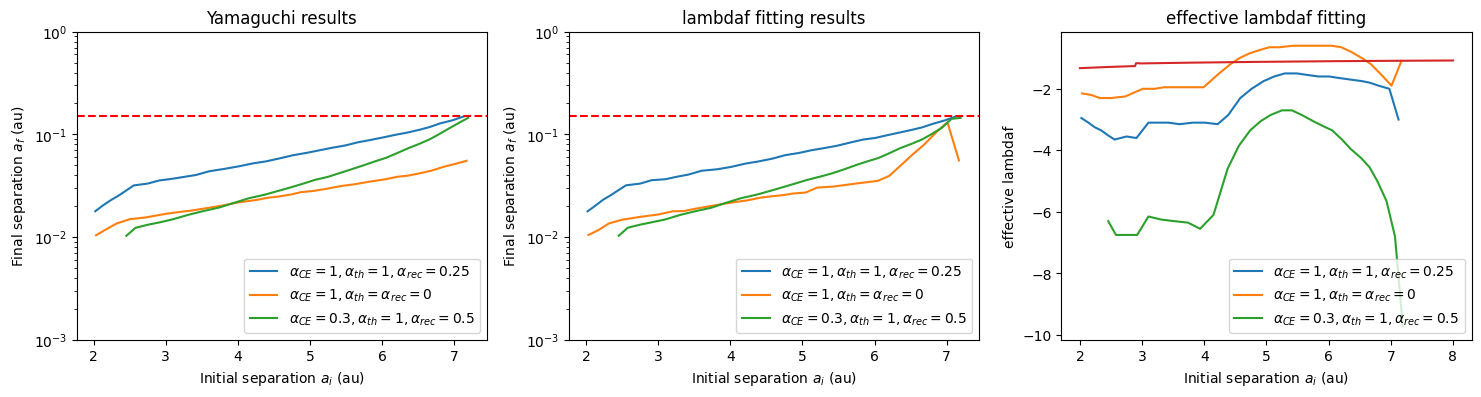

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
data = []
data.append(data1) # data[0] -- alpha = 1
data.append(data1)
data.append(data4) # data[1] -- alpha = 0.3

for i in range(len(x)):
    x_list = x[i]
    y_list = y[i]
    if i == 0: 
        axs[0].plot(x_list, y_list, label = r'$\alpha_{CE} = 1, \alpha_{th} = 1, \alpha_{rec} = 0.25$')
    elif i == 1: 
        axs[0].plot(x_list, y_list, label = r'$\alpha_{CE} = 1, \alpha_{th} = \alpha_{rec} = 0$')
    elif i == 2: 
        axs[0].plot(x_list, y_list, label = r'$\alpha_{CE} = 0.3, \alpha_{th} = 1, \alpha_{rec} = 0.5$')

for i in range(len(x)):
    x_list = x[i]
    y_list = y[i]
    indexList = findNearestList(ai_list, x_list)
    res = []
    lambdaFitting = []
    for j in range(len(x_list)):
        resultCol = data[i][:, indexList[j]].tolist()
        lambdaIndex = findNearest(resultCol, y_list[j])
        res.append(data[i][lambdaIndex][indexList[j]])
        lambdaFitting.append(lambdaList[lambdaIndex])
    print(f'i = {i}')
    print(lambdaFitting)
    if i == 0: 
        axs[1].plot(x_list, res, label = r'$\alpha_{CE} = 1, \alpha_{th} = 1, \alpha_{rec} = 0.25$')
        axs[2].plot(x_list, lambdaFitting, label = r'$\alpha_{CE} = 1, \alpha_{th} = 1, \alpha_{rec} = 0.25$')
    elif i == 1: 
        axs[1].plot(x_list, res, label = r'$\alpha_{CE} = 1, \alpha_{th} = \alpha_{rec} = 0$')
        axs[2].plot(x_list, lambdaFitting, label = r'$\alpha_{CE} = 1, \alpha_{th} = \alpha_{rec} = 0$')
    elif i == 2: 
        axs[1].plot(x_list, res, label = r'$\alpha_{CE} = 0.3, \alpha_{th} = 1, \alpha_{rec} = 0.5$')
        axs[2].plot(x_list, lambdaFitting, label = r'$\alpha_{CE} = 0.3, \alpha_{th} = 1, \alpha_{rec} = 0.5$')

axs[0].set_xlabel('Initial separation $a_i$ (au)')
axs[0].set_ylabel('Final separation $a_f$ (au)')
axs[0].legend(loc='lower right')
axs[0].set_title('Yamaguchi results')
axs[0].axhline(y=0.15, color='red', linestyle='--')
axs[0].set_yscale('log')
axs[0].set_ylim(10**(-3), 1)

axs[1].set_xlabel('Initial separation $a_i$ (au)')
axs[1].set_ylabel('Final separation $a_f$ (au)')
axs[1].legend(loc='lower right')
axs[1].set_title('lambdaf fitting results')
axs[1].axhline(y=0.15, color='red', linestyle='--')
axs[1].set_yscale('log')
axs[1].set_ylim(10**(-3), 1)

axs[2].set_xlabel('Initial separation $a_i$ (au)')
axs[2].set_ylabel('effective lambdaf')
axs[2].legend(loc='lower right')
axs[2].set_title('effective lambdaf fitting')
axs[2].plot(ai_list, default, label = r'$\alpha_{CE} = 1.0$, Claeys 2014')

# Display the plot
plt.savefig('7+1 fitting lambdaf energy budget cmp.png', dpi=300)
plt.show()